I'll be training a model That classifies tweets into +ve or -ve.
The dataset for training, I chose “Sentiment140”, which originated from Stanford University. More info on the dataset can be found from the link. http://help.sentiment140.com/for-students/
The dataset can be downloaded from the below link.
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

## Data cleaning
Let's look at the data first

In [32]:
from bs4 import BeautifulSoup
import re

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cols=['sentiment','id','date','query','user','text']
df = pd.read_csv("training.csv" ,header=None,encoding='latin-1',names=cols)
df.sample(10)

,sentiment,id,date,query,user,text
693195,0,2252668116,Sat Jun 20 06:45:24 PDT 2009,NO_QUERY,Bulldog36,"Hope all is well with everyone, Hey! I sure wi..."
143827,0,1881822934,Fri May 22 05:38:29 PDT 2009,NO_QUERY,laurenblondina,"Sad, upset, and hurt..."
1146948,4,1978009781,Sat May 30 22:13:10 PDT 2009,NO_QUERY,sashafierceme,"@kBROwn49 The belly dancers, hookah, music, t..."
724902,0,2262188668,Sat Jun 20 22:02:39 PDT 2009,NO_QUERY,ohjoyitsmandie,seriously upset over something so stupid. or ...
734223,0,2264502526,Sun Jun 21 04:04:32 PDT 2009,NO_QUERY,mr_billiam,@vipvirtualsols it was on tinychat rather than...
648050,0,2236923663,Fri Jun 19 04:49:51 PDT 2009,NO_QUERY,lewsea,@princessimmie i don't know &amp; she probabl...
278140,0,1991455760,Mon Jun 01 07:04:17 PDT 2009,NO_QUERY,Funkist,"glad her Norwegian &quot;host&quot; aunt, Gro,..."
447627,0,2068755004,Sun Jun 07 14:38:24 PDT 2009,NO_QUERY,Naturally_Flyy,I think my babay is sick
507555,0,2188927010,Mon Jun 15 22:51:39 PDT 2009,NO_QUERY,kandjar,Other deception about Marble World 2: PPC vers...
210508,0,1974259037,Sat May 30 12:45:46 PDT 2009,NO_QUERY,NataliexUndead,My summer plans just fell through.


the polarity of the tweet (0 = negative, 4 = positive)'

Let's drop unnecessary columns like id, user, date, query

In [9]:
df.drop(['id','date','query','user'],axis=1,inplace=True)

In [10]:
df[df.sentiment==0].head() #negative tweets

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
df[df.sentiment==4].head #positive tweets

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


In [13]:
df['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

There are 8,00,000 tweets for each category,, so in total there are 16,00,000 tweets

In [14]:
df['pre_clean_len'] = [len(t) for t in df.text]
df

,sentiment,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,56
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,78
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,57
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,65


Let's look at the distribution of overall length of strings in each record

Im gonna plot a box plot...

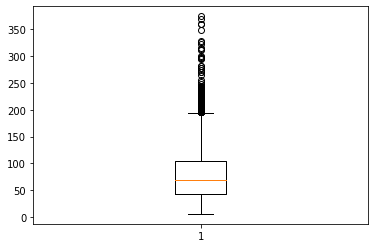

In [15]:
plt.boxplot(df.pre_clean_len)
plt.show()

This seems strange cz the tweet limit is 140 characters, lets dive into this situation

In [19]:
df[df.pre_clean_len > 140].sample(10)

,sentiment,text,pre_clean_len
543978,0,2 shows &amp; 3 practices a week for @WaterSki...,142
860404,4,Fahh it's Lykk 5 in the avo &amp;&amp; I Juss ...,142
510043,0,@grum I use &quot;Four&quot; now at Gloria Jea...,167
906946,4,made a mysql table with 150 entries wrote a s...,141
1029424,4,: Richard &quot;Caveman&quot; Tandy rocked it!...,151
914176,4,but i didnt krystal spent the night last nigh...,142
983290,4,Was on first minutes of first date in Fullerto...,148
123564,0,Couldn't watch the Sox live on TV (Sunday) so ...,143
651218,0,@youhadmeathello where's your bio line from ag...,141
515035,0,brayden rafferzini. you didn't need that one d...,142


### Looks like it's cleaning time 👀

- HTML decoding (&amp, &quot..)
- '@'
- URL links
- Utf Byte Order Mark (\xef\xbf\xbd)
- Hashtag symbol

In [47]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pattern1= r'@[A-za-z0-9]+'
pattern2= r'https?://[A-Za-z0-9./]+'
combined =  r'|'.join((pattern1, pattern2))

def cleaner(text):
    #html decoding
    soup = BeautifulSoup(text,'lxml')
    souped = soup.get_text()
    # @ and URL links
    stripped = re.sub(combined, ' ', souped)
    
    #BOM
    try:
        clean = stripped.decode("utf-8-sig").replace(u"ufffd", "?")
    except:
        clean=stripped
    #removing numbers and converting to lowercase
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()  
    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(cleaner(t))
test_result
    

['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt m

In [61]:
nums = [0,400000,800000,1200000,1600000]
print( "Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[4]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[4] ))                                                           
    clean_tweet_texts.append(cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 10000 of 1600000 has been processed
Tweets 20000 of 1600000 has been processed
Tweets 30000 of 1600000 has been processed
Tweets 40000 of 1600000 has been processed
Tweets 50000 of 1600000 has been processed
Tweets 60000 of 1600000 has been processed
Tweets 70000 of 1600000 has been processed
Tweets 80000 of 1600000 has been processed
Tweets 90000 of 1600000 has been processed
Tweets 100000 of 1600000 has been processed
Tweets 110000 of 1600000 has been processed
Tweets 120000 of 1600000 has been processed
Tweets 130000 of 1600000 has been processed
Tweets 140000 of 1600000 has been processed
Tweets 150000 of 1600000 has been processed
Tweets 160000 of 1600000 has been processed
Tweets 170000 of 1600000 has been processed
Tweets 180000 of 1600000 has been processed
Tweets 190000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 210000 of 1600000 has been processed
Tweets 220000 of 1600000 has been processed
Tweet

C:\Users\saniy\Anaconda3\lib\site-packages\bs4\__init__.py:314: UserWarning: "b'E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \\../  \\../'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1600000 has been processed
Tweets 1430000 of 1600000 has been processed
Tweets 1440000 of 1600000 has been processed
Tweets 1450000 of 1600000 has been processed
Tweets 1460000 of 1600000 has been processed
Tweets 1470000 of 1600000 has been processed
Tweets 1480000 of 1600000 has been processed
Tweets 1490000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1510000 of 1600000 has been processed
Tweets 152

In [62]:
len(clean_tweet_texts)

1600000

In [63]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.tail()

,text,target
1599995,just woke up having no school is the best feel...,4
1599996,thewdb com very cool to hear old walt intervie...,4
1599997,are you ready for your mojo makeover ask me fo...,4
1599998,happy th birthday to my boo of alll time tupac...,4
1599999,happy charitytuesday,4


In [64]:
clean_df.to_csv('clean_df.csv')